In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import env
import numpy as np
from matplotlib import cm
from sklearn.model_selection import learning_curve
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split

In [40]:
def get_connection(db, user=env.username, host=env.host, password=env.password):
    
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def new_zillow_data():
   
    sql_query = """
             
    select * from properties_2017
    join predictions_2017 as p using(parcelid)
    inner join predictions_2017 pred on properties_2017.parcelid = p.parcelid
    where propertylandusetypeid = 261
    and p.transactiondate = 2017;

                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    df = df.drop(columns='id')
    df = df.drop_duplicates(subset=['parcelid'],keep = 'last')
    df = df.dropna(subset=['latitude'])
    return df

In [ ]:
df= new_zillow_data()

In [4]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,485713.0,1023282.0,2016.0,537569.0,11013.72,None,NaN,6.059063e+13,0.025595,2017-01-01
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,88000.0,464000.0,2016.0,376000.0,5672.48,None,NaN,6.111001e+13,0.055619,2017-01-01
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,85289.0,564778.0,2016.0,479489.0,6488.30,None,NaN,6.059022e+13,0.005383,2017-01-01
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,108918.0,145143.0,2016.0,36225.0,1777.51,None,NaN,6.037300e+13,-0.103410,2017-01-01
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,73681.0,119407.0,2016.0,45726.0,1533.89,None,NaN,6.037124e+13,0.006940,2017-01-01


In [5]:
df.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,7.738100e+04,24953.000000,206.000000,50.000000,77381.000000,77381.000000,15.000000,49672.000000,76772.000000,614.0,...,17560.000000,172.0,7.726900e+04,7.738000e+04,77381.0,7.737900e+04,77376.000000,2886.000000,7.713700e+04,77381.000000
mean,1.300715e+07,1.813289,7.388350,679.720000,2.299130,3.053489,3.933333,6.534587,2.316867,66.0,...,1.434738,1.0,1.893145e+05,4.901345e+05,2016.0,3.010954e+05,5995.532346,14.087318,6.049673e+13,0.016625
std,3.481346e+06,2.967894,2.734542,689.703546,0.996651,1.139096,0.258199,1.721953,0.979755,0.0,...,0.544569,0.0,2.300874e+05,6.534440e+05,0.0,4.925960e+05,7622.844153,2.185663,1.535242e+12,0.170191
min,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,...,1.000000,1.0,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,-4.655420
25%,1.153830e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,...,1.000000,1.0,8.426500e+04,2.070000e+05,2016.0,8.550400e+04,2715.632500,14.000000,6.037311e+13,-0.024377
50%,1.253157e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,...,1.000000,1.0,1.364990e+05,3.589755e+05,2016.0,2.033720e+05,4450.695000,15.000000,6.037603e+13,0.006627
75%,1.421183e+07,1.000000,7.000000,796.500000,3.000000,4.000000,4.000000,8.000000,3.000000,66.0,...,2.000000,1.0,2.187870e+05,5.690015e+05,2016.0,3.667965e+05,6927.790000,15.000000,6.059042e+13,0.039203
max,1.676893e+08,13.000000,21.000000,3560.000000,18.000000,16.000000,4.000000,12.000000,18.000000,66.0,...,6.000000,1.0,1.142179e+07,4.906124e+07,2016.0,4.895220e+07,586639.300000,99.000000,4.830301e+14,5.262999


In [6]:
df[df.parcelid == 11991059]

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
43842,11991059,NaN,NaN,NaN,6.0,12.0,NaN,5.0,6.0,NaN,...,225228.0,2485282.0,2016.0,2260054.0,30342.87,None,NaN,NaN,2.508444,2017-06-13


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77381 entries, 0 to 77612
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77381 non-null  int64  
 1   airconditioningtypeid         24953 non-null  float64
 2   architecturalstyletypeid      206 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77381 non-null  float64
 5   bedroomcnt                    77381 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49672 non-null  float64
 8   calculatedbathnbr             76772 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6023 non-null   float64
 11  calculatedfinishedsquarefeet  77185 non-null  float64
 12  finishedsquarefeet12          73749 non-null  float64
 13  f

In [8]:
df.poolcnt = df.poolcnt.replace(np.NaN, 0).astype('object')
df.bathroomcnt = df.bathroomcnt.astype('object')
df.bedroomcnt= df.bedroomcnt[df.bedroomcnt > 0].astype('object')
df.roomcnt= df.roomcnt.astype('object')
df.logerror = df.logerror.astype('object')

In [9]:
df.fips=df.fips.astype('object')

In [10]:

def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final


In [11]:
df = remove_outlier_IQR(df)

/var/folders/3p/xpgnq5_d0cz13g99y3v4g03r0000gn/T/ipykernel_35044/3946405261.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77381 entries, 0 to 77612
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77350 non-null  float64
 1   airconditioningtypeid         23133 non-null  float64
 2   architecturalstyletypeid      172 non-null    float64
 3   basementsqft                  46 non-null     float64
 4   bathroomcnt                   77381 non-null  object 
 5   bedroomcnt                    76551 non-null  object 
 6   buildingclasstypeid           14 non-null     float64
 7   buildingqualitytypeid         49521 non-null  float64
 8   calculatedbathnbr             74784 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      5739 non-null   float64
 11  calculatedfinishedsquarefeet  73191 non-null  float64
 12  finishedsquarefeet12          69895 non-null  float64
 13  f

In [13]:
def null_counter(df):
    
    new_columns = ['name', 'num_rows_missing', 'pct_rows_missing']
    
    new_df = pd.DataFrame(columns=new_columns)
    
    for col in list(df.columns):
        num_missing = df[col].isna().sum()
        pct_missing = num_missing / df.shape[0]
        
        add_df = pd.DataFrame([{'name': col, 'num_rows_missing': num_missing,
                               'pct_rows_missing': pct_missing}])
        
        new_df = pd.concat([new_df, add_df], axis=0)
        
    new_df.set_index('name', inplace=True)
    
    return new_df

In [14]:
null_df = null_counter(df)
null_df

,num_rows_missing,pct_rows_missing
name,,
parcelid,31,0.000401
airconditioningtypeid,54248,0.701051
architecturalstyletypeid,77209,0.997777
basementsqft,77335,0.999406
bathroomcnt,0,0.000000
bedroomcnt,830,0.010726
buildingclasstypeid,77367,0.999819
buildingqualitytypeid,27860,0.360037
calculatedbathnbr,2597,0.033561


In [15]:

to_drop = null_df.index[null_df.pct_rows_missing > .25].to_list()
to_drop

['airconditioningtypeid',
 'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'lotsizesquarefeet',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertyzoningdesc',
 'regionidneighborhood',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories',
 'fireplaceflag',
 'taxdelinquencyflag',
 'taxdelinquencyyear']

In [16]:
def null_dropper(df,threshold):
    null_df = null_counter(df)
    to_drop = null_df.index[null_df.pct_rows_missing > threshold].to_list()
    new_df = df.drop(columns=to_drop)
    
    return new_df

In [17]:
df.fips.value_counts()

6037.0    50551
6059.0    20593
6111.0     6237
Name: fips, dtype: int64

In [18]:
df = null_dropper(df,.25)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77381 entries, 0 to 77612
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77350 non-null  float64
 1   bathroomcnt                   77381 non-null  object 
 2   bedroomcnt                    76551 non-null  object 
 3   calculatedbathnbr             74784 non-null  float64
 4   calculatedfinishedsquarefeet  73191 non-null  float64
 5   finishedsquarefeet12          69895 non-null  float64
 6   fips                          77381 non-null  object 
 7   fullbathcnt                   74806 non-null  float64
 8   latitude                      77272 non-null  float64
 9   longitude                     75177 non-null  float64
 10  poolcnt                       77381 non-null  object 
 11  propertycountylandusecode     77381 non-null  object 
 12  propertylandusetypeid         74037 non-null  float64
 13  r

In [19]:
df = df.drop(columns='propertycountylandusecode')

In [20]:
df.transactiondate = df.transactiondate.str[5:7]

In [21]:
train, validate = train_test_split(df, random_state=123)
train, test = train_test_split(train, random_state=123)

In [22]:
def handle_nulls(df):
    cols = df.columns.to_list()
    imp_mode = IterativeImputer(initial_strategy='most_frequent',skip_complete=True)
    imp_mode.fit(df)
    tdf = imp_mode.transform(df)
    new_df = pd.DataFrame(tdf)
    new_df.columns = cols
    
    return new_df


In [23]:
train = handle_nulls(train)
validate = handle_nulls(validate)
test = handle_nulls(test)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43526 entries, 0 to 43525
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      43526 non-null  float64
 1   bathroomcnt                   43526 non-null  float64
 2   bedroomcnt                    43526 non-null  float64
 3   calculatedbathnbr             43526 non-null  float64
 4   calculatedfinishedsquarefeet  43526 non-null  float64
 5   finishedsquarefeet12          43526 non-null  float64
 6   fips                          43526 non-null  float64
 7   fullbathcnt                   43526 non-null  float64
 8   latitude                      43526 non-null  float64
 9   longitude                     43526 non-null  float64
 10  poolcnt                       43526 non-null  float64
 11  propertylandusetypeid         43526 non-null  float64
 12  rawcensustractandblock        43526 non-null  float64
 13  r

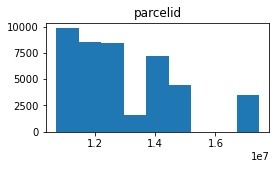

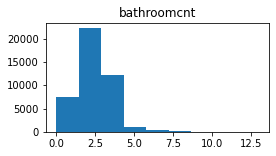

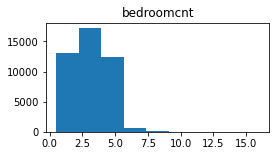

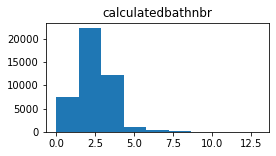

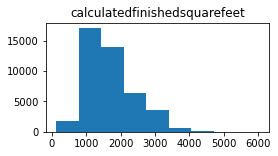

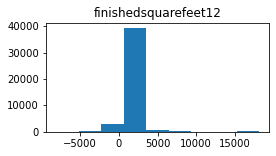

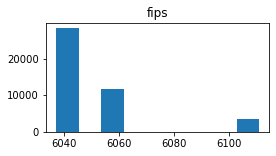

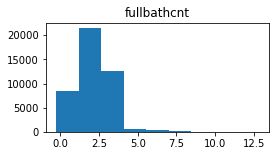

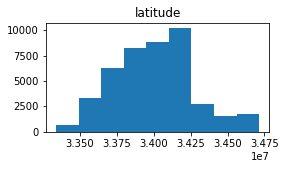

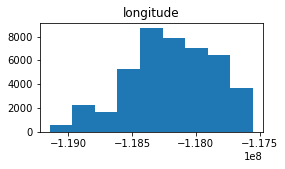

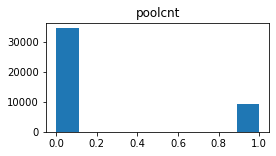

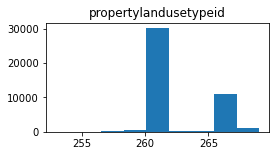

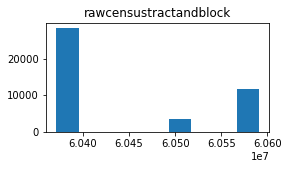

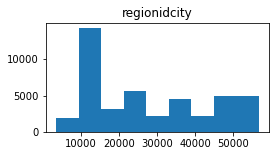

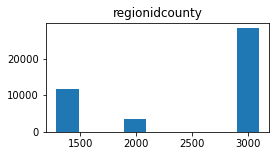

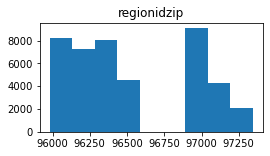

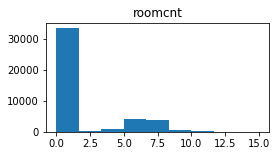

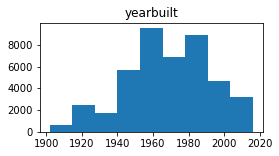

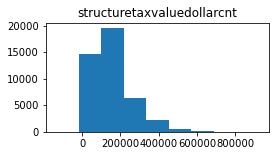

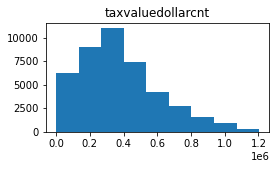

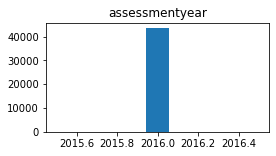

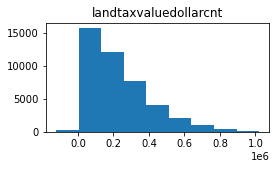

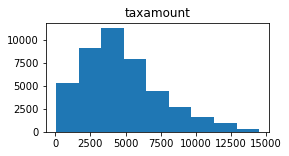

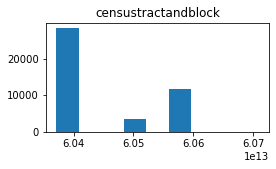

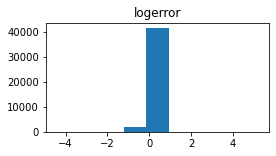

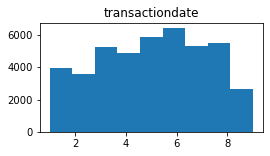

In [24]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col], bins = 9)
    plt.title(col)
    plt.show()


In [25]:
train.fips.value_counts

<bound method IndexOpsMixin.value_counts of 0        6037.0
1        6037.0
2        6037.0
3        6037.0
4        6037.0
          ...  
43521    6037.0
43522    6111.0
43523    6037.0
43524    6037.0
43525    6059.0
Name: fips, Length: 43526, dtype: float64>

<AxesSubplot:xlabel='logerror', ylabel='roomcnt'>

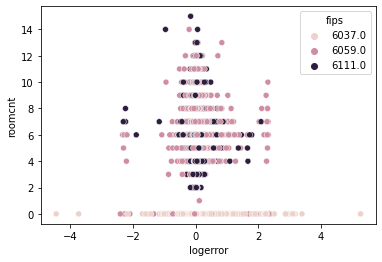

In [26]:
sns.scatterplot(y=train.roomcnt,x=train.logerror, hue=train.fips)

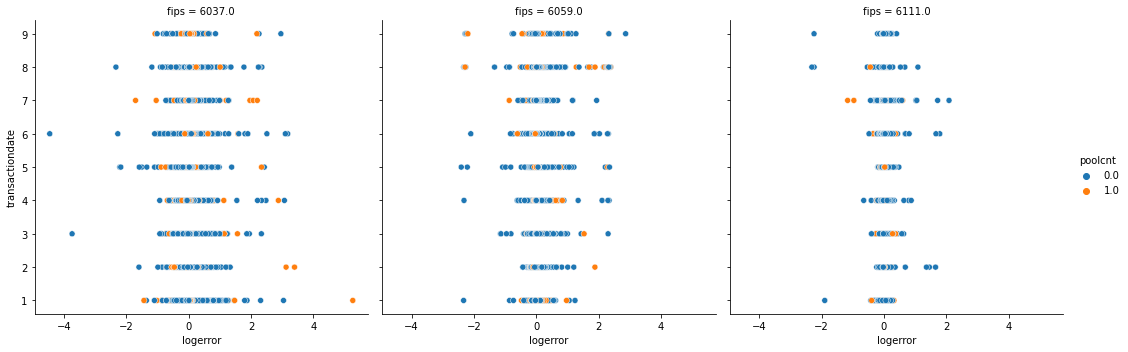

In [27]:

sns.relplot(x='logerror',y='transactiondate',hue='poolcnt',col='fips',data=train)



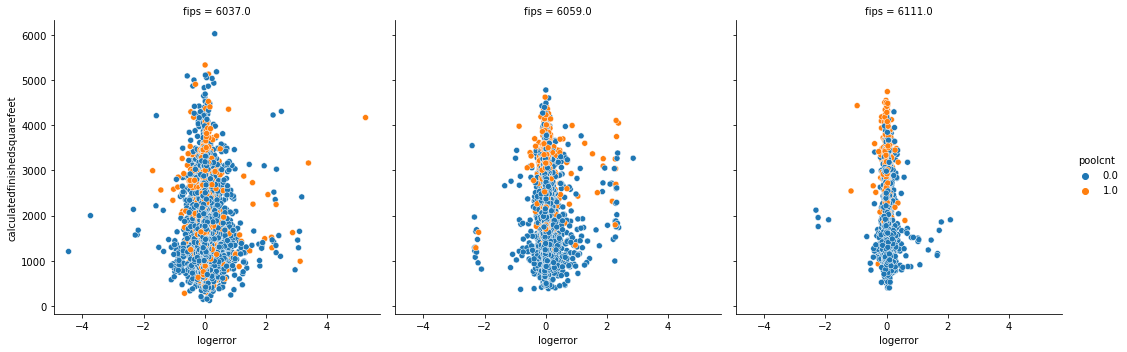

In [28]:
sns.relplot(x='logerror',y='calculatedfinishedsquarefeet',hue='poolcnt',col='fips',data=train)

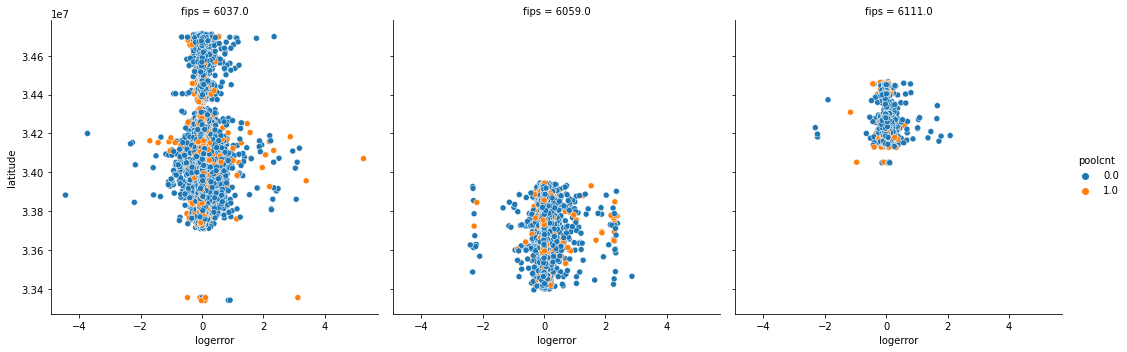

In [29]:
sns.relplot(x='logerror',y='latitude',hue='poolcnt',col='fips',data=train)

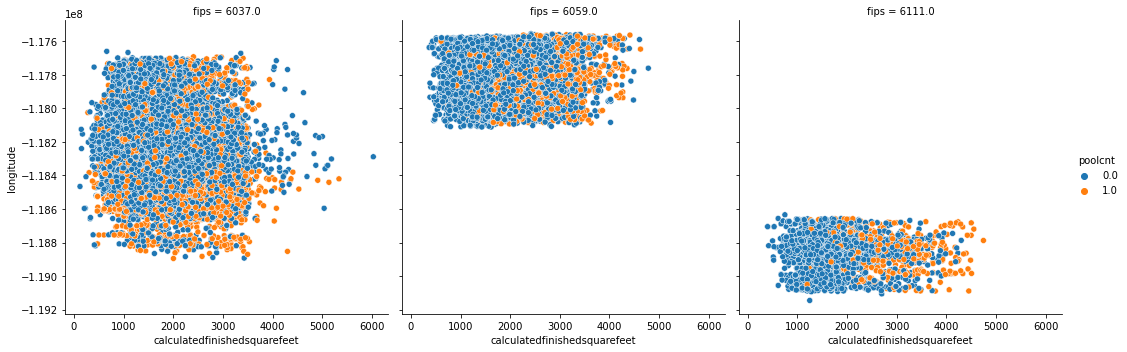

In [30]:
sns.relplot(x='calculatedfinishedsquarefeet',y='longitude',hue='poolcnt',col='fips',data=train)

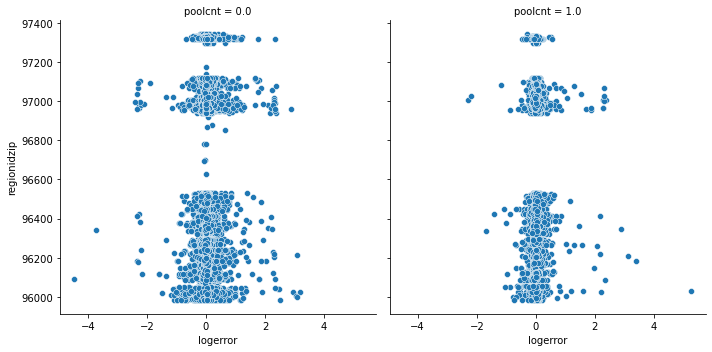

In [31]:
sns.relplot(x='logerror',y='regionidzip',col='poolcnt',data=train)

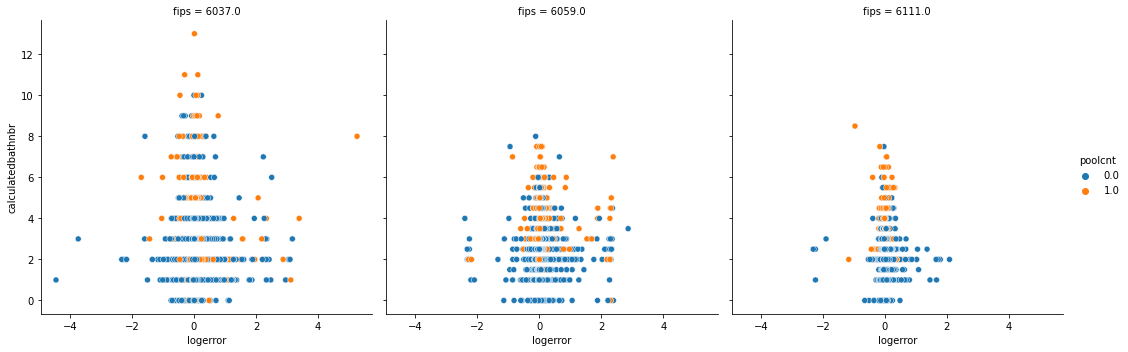

In [34]:
sns.relplot(x='logerror',y='calculatedbathnbr',hue='poolcnt',col='fips',data=train)

In [35]:
train.corr()

,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,longitude,...,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate
parcelid,1.000000,-0.018063,0.014462,-0.018062,0.058218,0.261990,0.916061,-0.096252,-0.349185,0.074058,...,0.679352,0.227227,0.043568,0.084865,NaN,0.084699,0.017670,0.744992,0.013389,-0.001271
bathroomcnt,-0.018063,1.000000,0.624385,1.000000,0.749547,0.179741,0.013933,0.985332,0.028929,-0.036909,...,0.038157,0.373634,0.487214,0.368272,NaN,0.193205,0.386620,0.024333,0.024690,0.015485
bedroomcnt,0.014462,0.624385,1.000000,0.624385,0.706339,0.154860,0.040673,0.619543,0.070581,-0.016305,...,0.166652,0.042128,0.306454,0.236637,NaN,0.128005,0.260092,0.016625,0.030176,0.010935
calculatedbathnbr,-0.018062,1.000000,0.624385,1.000000,0.749547,0.179741,0.013933,0.985332,0.028929,-0.036909,...,0.038157,0.373634,0.487214,0.368272,NaN,0.193205,0.386620,0.024333,0.024690,0.015485
calculatedfinishedsquarefeet,0.058218,0.749547,0.706339,0.749547,1.000000,0.449285,0.090795,0.725574,0.011267,-0.014318,...,0.150434,0.233212,0.596042,0.467840,NaN,0.258704,0.480407,0.095643,0.033232,0.015878
finishedsquarefeet12,0.261990,0.179741,0.154860,0.179741,0.449285,1.000000,0.278079,0.145139,-0.030175,-0.000769,...,0.265954,0.230166,0.285685,0.243303,NaN,0.148689,0.220374,0.230319,0.012730,0.011464
fips,0.916061,0.013933,0.040673,0.013933,0.090795,0.278079,1.000000,-0.055236,-0.068629,-0.254503,...,0.708520,0.235829,0.085914,0.087658,NaN,0.063610,0.029874,0.629425,0.006737,0.001060
fullbathcnt,-0.096252,0.985332,0.619543,0.985332,0.725574,0.145139,-0.055236,1.000000,0.080285,-0.070387,...,-0.012188,0.328947,0.469182,0.344464,NaN,0.172848,0.367953,-0.066631,0.022906,0.016106
latitude,-0.349185,0.028929,0.070581,0.028929,0.011267,-0.030175,-0.068629,0.080285,1.000000,-0.607195,...,-0.201307,0.001064,0.051950,-0.150000,NaN,-0.224831,-0.079362,-0.583381,-0.010904,-0.003747
longitude,0.074058,-0.036909,-0.016305,-0.036909,-0.014318,-0.000769,-0.254503,-0.070387,-0.607195,1.000000,...,-0.010430,0.076637,-0.090198,-0.001729,NaN,0.050418,-0.023737,0.448441,0.018329,-0.008720
